## Image Forgery Detection

### Objective:

* Given an image,the task is to find out if it has been forged/tampered.

In [1]:
#Importing all the necessary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from tqdm import tqdm
import random
from keras.utils.np_utils import to_categorical 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
import os
from PIL import Image, ImageChops, ImageEnhance
from IPython.display import display # to display images


Using TensorFlow backend.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ubuntu/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ubuntu/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ubuntu/anaconda3/lib/python3.6/site-packages/tenso

Citation link: https://researchweb.iiit.ac.in/~anurag.ghosh/static/detection-localization-image.pdf

Error Level Analysis: 
It works by intentionally resaving the JPEG image at
a known error rate and then computing the difference between the images. Any modification to the picture will alter
the image such that stable areas become unstable. Differently compressed versions of the image are compared with
the possibly tampered one.


* ELA exploits the lossy compression of JPEG images. When an image is altered, the compression ratio of the specific portion changes with respect to other parts. 
http://www.hackerfactor.com/papers/bh-usa-07-krawetz-wp.pdf





Error Level Analysis is based on characteristics of image formats that are based on lossy image compression. This method can highlight areas of an image which has different degrees of compression. Especially the JPEG format (one of the most popular image formats on the Internet) can be applied particularly well using this method.

JPEG uses a lossy image compression. Each re-encoding process (new saving) performed on the image leads to further loss of quality. The JPEG algorithm is based on a 8x8 pixel grid. Each 8x8 square grid is thereby treated and compressed separately. If the image is untouched, then all these 8x8 squares will show the same error level potential.

If the jpeg image is saved again, then each square should be continuously reduced to approximately the same level. In the ELA process, the original image that is being examined will be resaved at a certain JPEG quality level (for example, at 75%). The resave leads to a known degree of compression, which extends over the entire image. The newly saved image is used to be compared with the original image. The human eye would hardly notice a change. Therefore, the ELA representation will visualize in particular only the difference between the two images. So, the resulting ELA image shows the varying degrees of compression potentials.

#### ==========================================================
Here's an amazing online tool you can use to understand how it works:

* https://29a.ch/photo-forensics/#error-level-analysis 

* Click open file and experiment it with your own set of images

#### ==========================================================

### Approach used for this problem:
* 1) Feature engineering part : Error Level Analysis (ELA)
and machine learning with deep learning techniques in the form of CNN
* 2) Instead of using the array/image matrix from raw image data of pristine and tampered images, we make use of ELA in the learning engine in an effort to increase efficiency of  Convolutional Neural Network (CNN).
* 3) This is much better than using just image matrix obtained from raw images as our input and the results obtained were also much better.

### Training and testing :
* For training we are going to use the CASIAV2 splicing Dataset provided by CASIA(Chinese Academy Of Sciences Institute Of Automation)


* CASIA provides spliced and copy-moved images of various objects. 
The tampered regions are carefully selected
and some post processing like filtering and blurring is also
applied.

* For testing we shall first evaluate using CASIA's validation set and also test with another standard dataset that was given in the IEEE IFS-TC Image Forensics Challenge to evaluate the model.

In [45]:
#https://gist.github.com/cirocosta/33c758ad77e6e6531392
#error level analysis of an image
def ELA(img_path):
    """Performs Error Level Analysis over a directory of images"""
    
    TEMP = 'ela_' + 'temp.jpg'
    SCALE = 10
    original = Image.open(img_path)
    try:
        original.save(TEMP, quality=90)
        temporary = Image.open(TEMP)
        diff = ImageChops.difference(original, temporary)
        
    except:
        
        original.convert('RGB').save(TEMP, quality=90)
        temporary = Image.open(TEMP)
        diff = ImageChops.difference(original.convert('RGB'), temporary)
        
       
    d = diff.load()
    
    WIDTH, HEIGHT = diff.size
    for x in range(WIDTH):
        for y in range(HEIGHT):
            print(d[x,y])
            d[x, y] = tuple(k * SCALE for k in d[x, y])

    return diff


The steps of ELA are summarized below:

* 1)read in image as JPEG

* 2) write image as JPEG with Quality lower level (eg. 90)

* 3)read in compressed image (decompress)

* 4)take absolute value of the difference between the decompressed image in step 3 and the original image in step 1

* Sample:
Let's perform ELA for an image which is original and another image which is tampered or fake.

In [ ]:
#Au_ani_00068.jpg
#Tp_D_CND_S_N_ani00073_ani00068_00193.tif

### Original image

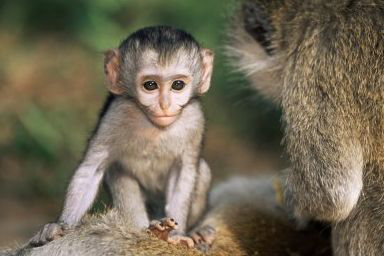

In [8]:
orig_img = Image.open('casia_dataset/Au/Au_ani_00068.jpg')
display(orig_img)

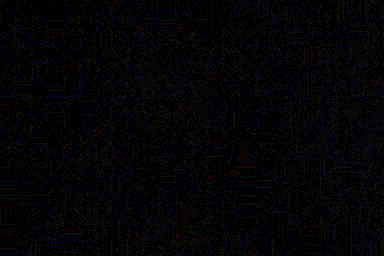

In [6]:
ELA('casia_dataset/Au/Au_ani_00068.jpg')

### Tampered Image

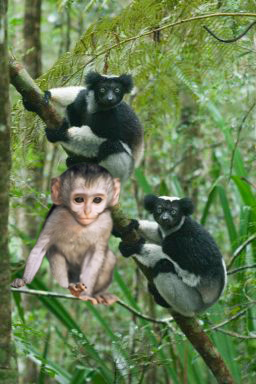

In [9]:
tampered_img = Image.open('casia_dataset/Tp/Tp_D_CND_S_N_ani00073_ani00068_00193.tif')
display(tampered_img)

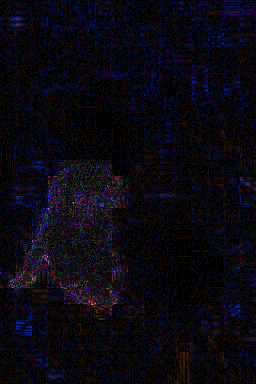

In [10]:
ELA('casia_dataset/Tp/Tp_D_CND_S_N_ani00073_ani00068_00193.tif')

* we can infer that When an image is altered, the compression ratio of the specific portion changes with respect to other parts.


### Few tampered images from the dataset

* Let's perform ELA on tampered images which are not so obvious to the human eye.

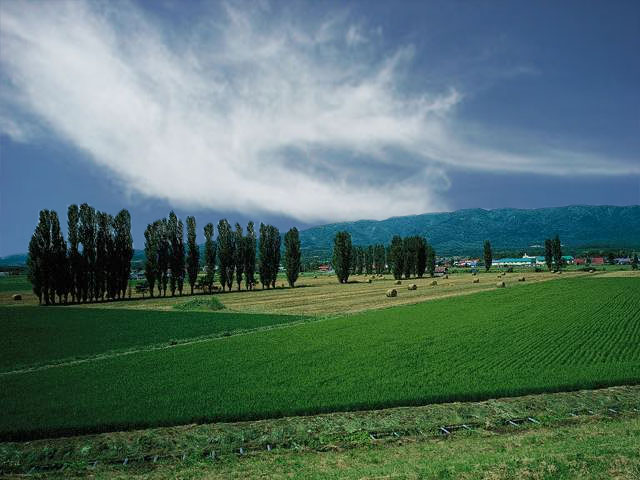

In [13]:
#tampered image
Image.open('casia_dataset/Tp/Tp_D_CRN_M_N_nat10131_nat10124_11906.jpg')

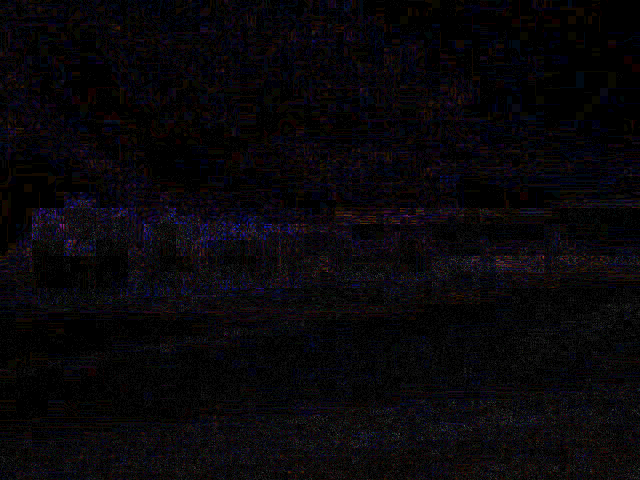

In [12]:
ELA('casia_dataset/Tp/Tp_D_CRN_M_N_nat10131_nat10124_11906.jpg')

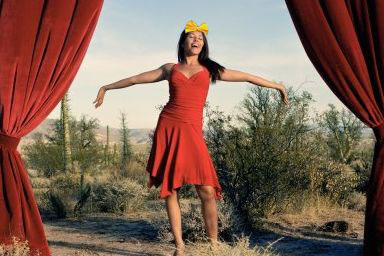

In [15]:
Image.open('casia_dataset/Tp/Tp_D_CRN_S_N_cha00063_art00014_11818.jpg')

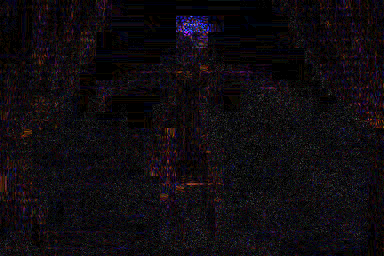

In [16]:
ELA('casia_dataset/Tp/Tp_D_CRN_S_N_cha00063_art00014_11818.jpg')

* Looks like the ribbon on her head is tampered.

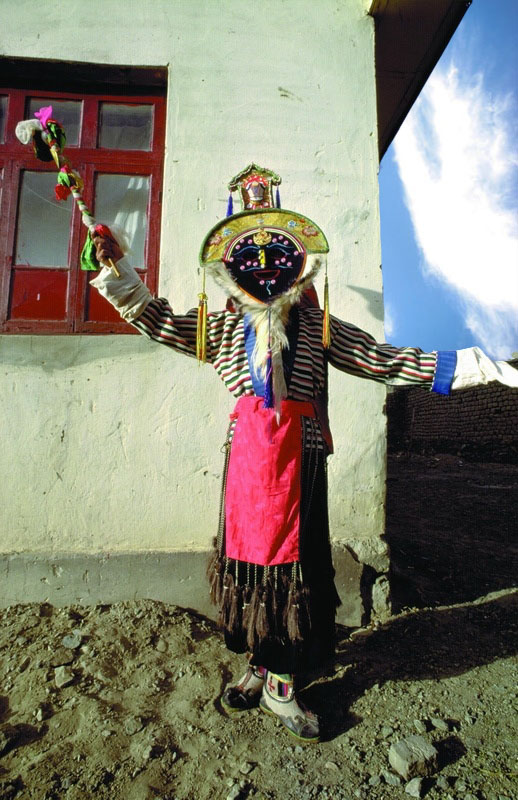

In [18]:
Image.open('casia_dataset/Tp/Tp_D_CRN_S_N_cha10122_nat10123_12168.jpg')

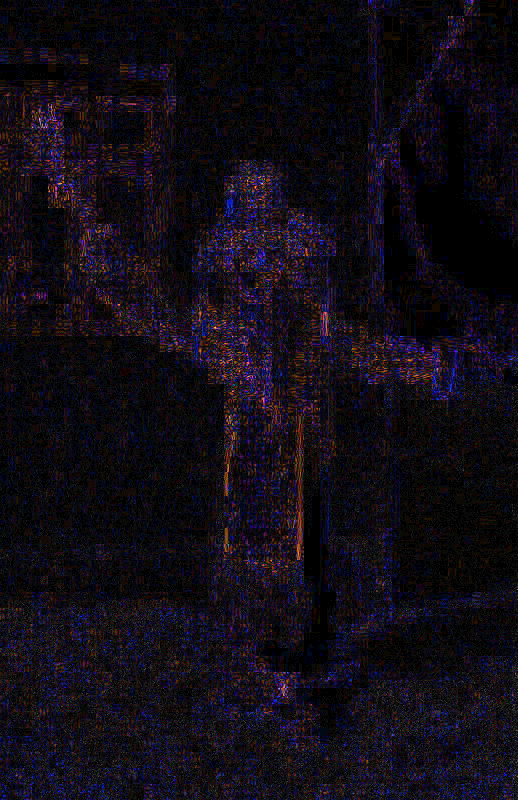

In [19]:
ELA('casia_dataset/Tp/Tp_D_CRN_S_N_cha10122_nat10123_12168.jpg')

### Preparing the dataset

In [ ]:
#Let's prepare the dataset 

* 1)Each picture as the input data is first converted first into image Error Level Analysis.Then,the ELA image will be resized to size 128 x 128.
* 2) Next we normalize by dividing each RGB value with the number 255.0 to do normalization, so that CNN converges faster.

In [4]:
path_original = 'casia_dataset/Au/'
path_tampered = 'casia_dataset/Tp/'

total_original = os.listdir(path_original)
total_tampered = os.listdir(path_tampered)

In [7]:
len(total_original)

7491

In [8]:
len(total_tampered)

5123

In [17]:
images = []

for file in tqdm(os.listdir(path_original)):
    try:
        if file.endswith('jpg'):
            if int(os.stat(path_original + file).st_size) > 10000:
                line = path_original + file  + ',0\n'
                images.append(line)
    except:
        print(path_original+file)



100%|██████████| 7491/7491 [00:00<00:00, 376146.67it/s]


In [18]:
for file in tqdm(os.listdir(path_tampered)):
    try:
        if file.endswith('jpg'):
            if int(os.stat(path_tampered + file).st_size) > 10000:
                    line = path_tampered + file + ',1\n'
                    images.append(line)
        if file.endswith('tif'):
            if int(os.stat(path_tampered + file).st_size) > 10000:
                    line = path_tampered + file + ',1\n'
                    images.append(line)
    except:
          print(path_tampered+file)



100%|██████████| 5123/5123 [00:00<00:00, 291192.96it/s]


In [19]:
len(images)

12389

In [20]:
image_name = []
label = []
for i in tqdm(range(len(images))):
    image_name.append(images[i][0:-3])
    label.append(images[i][-2])
    

100%|██████████| 12389/12389 [00:00<00:00, 943705.07it/s]


In [21]:
dataset = pd.DataFrame({'image':image_name,'class_label':label})

In [22]:
dataset['class_label'].value_counts()


0    7266
1    5123
Name: class_label, dtype: int64

### Class labels

It is important to note that:
* class label 1 ===>tampered
* class label 0====>real

In [5]:
dataset.head()

,image,class_label
0,casia_dataset/Au/Au_txt_10101.jpg,0
1,casia_dataset/Au/Au_sec_30475.jpg,0
2,casia_dataset/Au/Au_ind_00023.jpg,0
3,casia_dataset/Au/Au_arc_30432.jpg,0
4,casia_dataset/Au/Au_pla_30155.jpg,0


In [24]:
dataset.to_csv('dataset_casa2.csv',index=False)

In [4]:
dataset = pd.read_csv('dataset_casa2.csv')

In [6]:
len(dataset)

12389

In [7]:
x_casia = []
y_casia = []

In [8]:
for index, row in tqdm(dataset.iterrows()):
    x_casia.append(np.array(ELA(row[0]).resize((128, 128))).flatten() / 255.0)
    y_casia.append(row[1])

2396it [03:37, 13.13it/s]/home/ubuntu/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 2. Skipping tag 41487
  " Skipping tag %s" % (size, len(data), tag)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41988
  " Skipping tag %s" % (size, len(data), tag)
12389it [21:33,  9.58it/s]


In [10]:
#converting X and Y to numpy arrays
x_casia = np.array(x_casia)
y_casia = np.array(y_casia)


### Reshape X

In [11]:
x_casia = x_casia.reshape(-1, 128, 128, 3)

In [12]:
x_casia[0]

array([[[0.2745098 , 0.        , 0.2745098 ],
        [0.03921569, 0.19607843, 0.03921569],
        [0.15686275, 0.15686275, 0.15686275],
        ...,
        [0.19607843, 0.        , 0.23529412],
        [0.07843137, 0.11764706, 0.11764706],
        [0.2745098 , 0.15686275, 0.19607843]],

       [[0.15686275, 0.23529412, 0.07843137],
        [0.11764706, 0.19607843, 0.31372549],
        [0.19607843, 0.03921569, 0.11764706],
        ...,
        [0.39215686, 0.07843137, 0.        ],
        [0.19607843, 0.11764706, 0.15686275],
        [0.19607843, 0.03921569, 0.2745098 ]],

       [[0.11764706, 0.03921569, 0.07843137],
        [0.03921569, 0.        , 0.03921569],
        [0.03921569, 0.07843137, 0.19607843],
        ...,
        [0.03921569, 0.11764706, 0.2745098 ],
        [0.2745098 , 0.35294118, 0.70588235],
        [0.19607843, 0.23529412, 0.        ]],

       ...,

       [[0.07843137, 0.03921569, 0.39215686],
        [0.03921569, 0.03921569, 0.15686275],
        [0.03921569, 0

In [13]:
y_casia = to_categorical(y_casia, 2) #y is one hot encoded

In [14]:
y_casia[0] 

array([1., 0.], dtype=float32)

In [17]:
len(x_casia)

12389

### The kernel kept crashing in between and since preparing the dataset itself took 20 mins,the data set was saved and the kernel was restarted again.

In [19]:
from numpy import save
## save all the data 
save('X_casia.npy', x_casia)
save('Y_casia.npy',y_casia)

In [2]:
from numpy import load
x_casia = load('X_casia.npy')

In [3]:

y_casia = load('Y_casia.npy')

### Train-test split

In [4]:
X_train, X_val, Y_train, Y_val = train_test_split(x_casia, y_casia, test_size = 0.2, random_state=5)

In [ ]:
###model cnn

In [5]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'valid', 
                 activation ='relu', input_shape = (128,128,3)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'valid', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(2, activation = "softmax"))






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [6]:
optimizer = Adam()

In [7]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [8]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 124, 124, 32)      2432      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 120, 120, 32)      25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 60, 60, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 60, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 115200)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               29491456  
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)              

In [9]:
early_stopping = EarlyStopping(monitor='val_acc',
                              min_delta=0,
                              patience=2,
                              verbose=1, mode='auto')

In [10]:
history = model.fit(X_train, Y_train, batch_size = 100, epochs = 30, 
          validation_data = (X_val, Y_val), verbose = 1, callbacks=[early_stopping])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 9911 samples, validate on 2478 samples
Epoch 1/30
9911/9911 [==============================] - 334s 34ms/step - loss: 0.5866 - acc: 0.7624 - val_loss: 0.4990 - val_acc: 0.8329
Epoch 2/30
9911/9911 [==============================] - 332s 33ms/step - loss: 0.3449 - acc: 0.8776 - val_loss: 0.2839 - val_acc: 0.8846
Epoch 3/30
9911/9911 [==============================] - 332s 34ms/step - loss: 0.2467 - acc: 0.9032 - val_loss: 0.2602 - val_acc: 0.8959
Epoch 4/30
9911/9911 [==============================] - 332s 34ms/step - loss: 0.2189 - acc: 0.9136 - val_loss: 0.2571 - val_acc: 0.8955
Epoch 5/30
9911/9911 [==============================] - 333s 34ms/step - loss: 0.1914 - acc: 0.9225 - val_loss: 0.2508 - val_acc: 0.8830
Epoch 00005: early stopping


In [11]:
model.save('new_model_casia.h5')

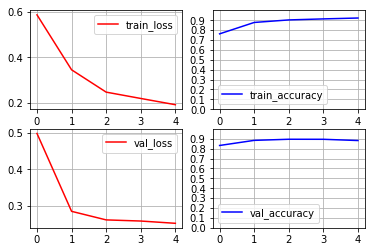

In [12]:
fig = plt.figure()
p1 = fig.add_subplot(221)
p2 = fig.add_subplot(222)
p3 = fig.add_subplot(223)
p4 = fig.add_subplot(224)
p2.set_ylim(0,1)
p4.set_ylim(0,1)
p1.grid()
p2.grid()
p3.grid()
p4.grid()
p2.set_yticks(np.arange(0,1,0.1))
p4.set_yticks(np.arange(0,1,0.1))
x = [i for i in range(5)]
y = history.history['loss']
y2 = history.history['acc']
y3 = history.history['val_loss']
y4 = history.history['val_acc']
p1.plot(x,y, 'r', label='train_loss')
p1.legend()
p2.plot(x,y2, 'b', label='train_accuracy')
p2.legend()
p3.plot(x,y3, 'r', label='val_loss')
p3.legend()
p4.plot(x,y4, 'b', label='val_accuracy')
p4.legend()
plt.show()

In [13]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
y_pred_cnn = model.predict(X_val)
y_pred_cnn = np.argmax(y_pred_cnn,axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 

score = metrics.precision_score(Y_true,y_pred_cnn, average= "weighted")
print("Precision score: {}".format(score))
score = metrics.recall_score(Y_true, y_pred_cnn, average= "weighted")
print("Recall score: {}".format(score))
score_lr1 = metrics.f1_score(Y_true, y_pred_cnn, average= "weighted")
print("F1 score: {}".format(score_lr1))

Precision score: 0.8935695551472155
Recall score: 0.8829701372074253
F1 score: 0.884202410800913


Confusion matrix:
 [[1282  229]
 [  61  906]]
              precision    recall  f1-score   support

           0       0.95      0.85      0.90      1511
           1       0.80      0.94      0.86       967

    accuracy                           0.88      2478
   macro avg       0.88      0.89      0.88      2478
weighted avg       0.89      0.88      0.88      2478

Plot of Confusion Matrix


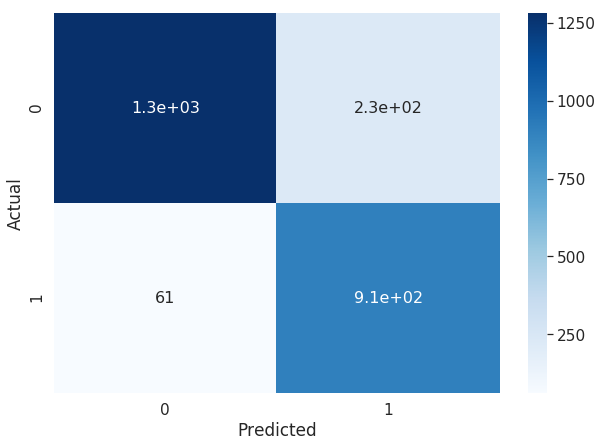

In [23]:
import seaborn as sns
cm = confusion_matrix(Y_true, y_pred_cnn)
print('Confusion matrix:\n',cm)

print(classification_report(Y_true, y_pred_cnn))

print('Plot of Confusion Matrix')
df_cm = pd.DataFrame(cm, columns=np.unique(Y_true), index = np.unique(Y_true))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

In [31]:
from sklearn.metrics import roc_auc_score
print('ROC_AUC score:',roc_auc_score(Y_true,y_pred_cnn))
df_cm

ROC_AUC score: 0.8926815213084057


Predicted,0,1
Actual,,
0,1282,229
1,61,906


* Now that we got an F1 score of 0.88 and have tested this on standard dataset like CASIA,
* Let's also test this model on another standard dataset which was provided in the  IEEE IFS-TC Image Forensics Challenge 
http://web.archive.org/web/20171013200331/http://ifc.recod.ic.unicamp.br/fc.website/index.py?sec=5




### Forensics challenge dataset

The dataset consists of 1050 pristine, 450 fake images and 450 Ground truths. Color images are usually 3 channel images one channel for each red, green and blue colors, however sometimes the fourth channel for yellow may be present. Images in our dataset are a mix of 1, 3 and 4 channel images.

In [23]:
#forensics challenge data
path_original = '/home/ubuntu/Downloads/phase-01-training/dataset-dist/phase-01/training/pristine/'
path_tampered = '/home/ubuntu/Downloads/phase-01-training/dataset-dist/phase-01/training/fake/'

total_orig = os.listdir(path_original)
total_tampered = os.listdir(path_tampered)

In [24]:
#https://stackoverflow.com/questions/47645115/oserror-cannot-identify-image-file-dataset-ds-store
total_tampered.remove('.DS_Store')

In [25]:
len(total_orig),len(total_tampered)

(1050, 900)

In [26]:
images = []

for file in tqdm(total_orig):  #choose all pristine
    try:
        if file.endswith('png'):
            if int(os.stat(path_original + file).st_size) > 10000:
                line = path_original + file  + ',0\n'
                images.append(line)
    except:
        print(path_original+file)
        
for file in tqdm(total_tampered):       #choose all tampered images
    try:
        if file.endswith('png'):
            if int(os.stat(path_tampered + file).st_size) > 10000:
                    line = path_tampered + file + ',1\n'
                    images.append(line)

    except:
          print(path_tampered+file)


100%|██████████| 900/900 [00:00<00:00, 311715.41it/s]


In [ ]:
#Now Randomly sampled 500 images from images list and test the model.

In [190]:
# rand_samp = set()
# while(len(rand_samp)<500):
#     index = random.randrange(0, len(images))
#     rand_samp.add(images[index])
    
    

In [41]:
X_f = []
Y_f = []

In [36]:
len(images)

1660

In [ ]:
####training for the entire 

In [37]:
image_name = []
label = []
for i in tqdm(range(len(images))):
    image_name.append(images[i][0:-3])
    label.append(images[i][-2])

100%|██████████| 1660/1660 [00:00<00:00, 1495713.13it/s]


In [39]:
dataset = pd.DataFrame({'image':image_name,'class_label':label})

In [ ]:
for index, row in dataset.iterrows():
    X_f.append(np.array(ELA(row[0]).resize((128, 128))).flatten() / 255.0)
    Y_f.append(row[1])

In [58]:
#converting X and Y to numpy arrays
X_f = np.array(X_f)
Y_f = np.array(Y_f)


In [59]:
X_f = X_f.reshape(-1, 128, 128, 3)
Y_f = to_categorical(Y_f, 2)     #y is one hot encoded

In [66]:
Y_f #one hot encoded

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

### Class labels

It is important to note that:
* class label 1 ===>tampered
* class label 0====>real

In [60]:
from keras.models import load_model
model = load_model('new_model_casia.h5')






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [61]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
y_pred_cnn = model.predict(X_f)
y_pred_cnn = np.argmax(y_pred_cnn,axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_f,axis = 1) 

score = metrics.precision_score(Y_true,y_pred_cnn, average= "weighted")
print("Precision score: {}".format(score))
score = metrics.recall_score(Y_true, y_pred_cnn, average= "weighted")
print("Recall score: {}".format(score))
score_lr1 = metrics.f1_score(Y_true, y_pred_cnn, average= "weighted")
print("F1 score: {}".format(score_lr1))

Precision score: 0.8562818605082835
Recall score: 0.7988929889298892
F1 score: 0.8124683474989798


Confusion matrix:
 [[1634  460]
 [  85  531]]
              precision    recall  f1-score   support

           0       0.95      0.78      0.86      2094
           1       0.54      0.86      0.66       616

    accuracy                           0.80      2710
   macro avg       0.74      0.82      0.76      2710
weighted avg       0.86      0.80      0.81      2710

Plot of Confusion Matrix


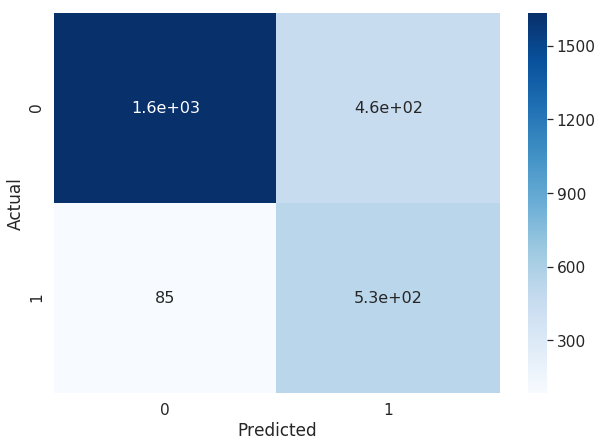

In [62]:
import seaborn as sns
cm = confusion_matrix(Y_true, y_pred_cnn)
print('Confusion matrix:\n',cm)

print(classification_report(Y_true, y_pred_cnn))

print('Plot of Confusion Matrix')
df_cm = pd.DataFrame(cm, columns=np.unique(Y_true), index = np.unique(Y_true))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})  # font size

### Observation and Results:


In [2]:
# Please compare all your models using Prettytable library
# http://zetcode.com/python/prettytable/
from prettytable import PrettyTable
#If you get a ModuleNotFoundError error ,pip install prettytable

x = PrettyTable()
x.field_names = ["Metrics(CASIAV2)",  "score"]
x.add_row(["F1-score",  0.88])
x.add_row(["Precision",  0.89])
x.add_row(["Recall",  0.88])
x.add_row(["Train accuracy(model)", 0.92])
x.add_row(["Validation accuracy(model)", 0.88])

print(x)


+----------------------------+-------+
|      Metrics(CASIAV2)      | score |
+----------------------------+-------+
|          F1-score          |  0.88 |
|         Precision          |  0.89 |
|           Recall           |  0.88 |
|   Train accuracy(model)    |  0.92 |
| Validation accuracy(model) |  0.88 |
+----------------------------+-------+


In [64]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Metrics(entire dataset Forensics challenge Dataset)",  "score"]
x.add_row(["F1-score",  0.812])
x.add_row(["Precision",  0.856])
x.add_row(["Recall",  0.798])


print(x)

+-----------------------------------------------------+-------+
| Metrics(entire dataset Forensics challenge Dataset) | score |
+-----------------------------------------------------+-------+
|                       F1-score                      | 0.812 |
|                      Precision                      | 0.856 |
|                        Recall                       | 0.798 |
+-----------------------------------------------------+-------+


* Other papers used for reference: CASIA Image Tampering Detection Evaluation Database
* Publisher: IEEE https://ieeexplore.ieee.org/document/6625374/authors#authors

* https://resources.infosecinstitute.com/error-level-analysis-detect-image-manipulation/